# Trabajo práctico N°2
## Detectando lugares del mundo.

Estos son datos de imágenes de escenas naturales de todo el mundo, contienen alrededor de 25.000 imágenes de tamaño 150x150
Las categorias en las que se busca entrenar el modelo son las siguientes:
* Buildings / Edificios
* Forest / Bosque
* Glacier / Glaciar
* Mountain / Montaña
* Sea / Mar
* Street / Calle

In [1]:
try:
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np

    import tensorflow as tf
    from tensorflow import keras
    from keras.models import Sequential
    from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, Conv2D, Flatten
    from tensorflow.keras.callbacks import Callback
    from tensorflow.keras.applications import VGG19, ResNet101
    from tensorflow.keras.applications.inception_v3 import InceptionV3
    from tensorflow.keras.models import Model
    from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
    from tensorflow.keras.layers import BatchNormalization
    from tensorflow.keras.optimizers import Adam
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.*")
    print("Se importó correctamente")
except Exception as e:
    print(f"Error al importar dependencias: {e}")

Se importó correctamente


In [2]:
img_folder_train = r"C:\UCSE\data-tp\train"
img_folder_test = r"C:\UCSE\data-tp\test"

# categorias propuestas
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

df = pd.DataFrame(columns=['filename', 'category'])

# Recorre cada subcarpeta
for category in categories:
    category_path = os.path.join(img_folder_train, category)  # Ruta completa de la subcarpeta
    for img_file in os.listdir(category_path):  # Recorre cada archivo en la subcarpeta
        if img_file.endswith(".jpg"):  # Filtra solo las imágenes con extensión .jpg
            img_path = os.path.join(category_path, img_file)  # Ruta completa de la imagen
            # Crea un DataFrame temporal con la categoría y el nombre del archivo
            temp_df = pd.DataFrame({'filename': [img_file], 'category': [category]})
            # Usa pd.concat para agregar al DataFrame principal
            df = pd.concat([df, temp_df], ignore_index=True)

# 1. Análisis exploratorio sobre el conjunto de datos.
* Volumetría de los datos: 14043 imágenes.

In [3]:
df.shape

(14034, 2)

* Estructura y tipo de las imágenes: 150x150 píxeles y están en formato .jpg

In [4]:
df.info

<bound method DataFrame.info of         filename   category
0          0.jpg  buildings
1      10006.jpg  buildings
2       1001.jpg  buildings
3      10014.jpg  buildings
4      10018.jpg  buildings
...          ...        ...
14029   9961.jpg     street
14030   9967.jpg     street
14031   9978.jpg     street
14032   9989.jpg     street
14033    999.jpg     street

[14034 rows x 2 columns]>

* Distribución de la variable a predecir: 'category'

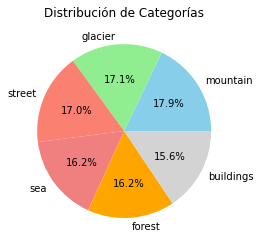

In [5]:
# Porcentaje de cada categoría
category_percent = df['category'].value_counts(normalize=True) * 100
category_percent.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'salmon', 'lightcoral', 'orange', 'lightgrey'])
plt.title('Distribución de Categorías')
plt.ylabel('')
plt.show()

La distribución de las categorías en el dataset muestra un equilibrio relativamente bueno entre las diferentes clases. Cada categoría presenta una proporción similar de imágenes, lo que sugiere que el modelo de aprendizaje automático tendrá suficiente información de cada clase para aprender a diferenciarlas.

Este balance en la distribución de clases es beneficioso, ya que ayuda a prevenir problemas de sobreajuste en el modelo y permite una mejor generalización. Sin embargo, se debe monitorear el rendimiento del modelo para asegurarse de que todas las categorías sean representadas adecuadamente durante el entrenamiento.

# 2. Modelado
### Preparación de datos

In [6]:
# Configura generador para entrenamiento con aumentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # División de validación dentro del generador
)

# Generador para el conjunto de validación (sin aumentación)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


# Cargar las imágenes en los generadores
train_generator = train_datagen.flow_from_directory(
    img_folder_train,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Subconjunto de entrenamiento
)

validation_generator = validation_datagen.flow_from_directory(
    img_folder_train,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Subconjunto de validación
)


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [7]:
# Visualización de la distribución del conjunto de entrenamiento
train_counts = pd.Series(train_generator.classes).value_counts()

# Visualización de la distribución del conjunto de validación
val_counts = pd.Series(validation_generator.classes).value_counts()

print("Distribución en el conjunto de entrenamiento:")
print(train_counts)

print("\nDistribución en el conjunto de validación:")
print(val_counts)


Distribución en el conjunto de entrenamiento:
3    2010
2    1924
5    1906
4    1820
1    1817
0    1753
Name: count, dtype: int64

Distribución en el conjunto de validación:
3    502
2    480
5    476
1    454
4    454
0    438
Name: count, dtype: int64


In [8]:
# Variables globales
input_shape=(150, 150, 3)
SIZE = 150

# Funcion para plotear resultados
def plot_history_result(history):
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

# Funcion para descargar en formato .csv los resultados obtenidos
def get_csv(directory, model, name_model):
    results = [] 
    images = [] 

    for image_name in os.listdir(directory):
        image_path = os.path.join(directory, image_name)

        if image_name.endswith(".jpg"):
            image_array = img_to_array(load_img(image_path, target_size=(SIZE, SIZE)))
            images.append(image_array)

    inputs = np.array(images) / 255.0

    predictions = model.predict(inputs)

    for i, image_name in enumerate(os.listdir(directory)):
        if image_name.endswith(".jpg"):
            predicted_class = categories[np.argmax(predictions[i])]
            results.append([image_name, predicted_class])

    df = pd.DataFrame(results, columns=["ID", "Label"])
    df.to_csv(name_model + ".csv", index=False)
    print("Predicciones guardadas en '" + name_model + ".csv'")

# CNN (Convolutional Neural Network)

In [6]:
model_CNN = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

model_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
history_CNN = model_CNN.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)


Epoch 1/10
350/350 [==============================] - 252s 719ms/step - loss: 3.7484 - accuracy: 0.4684 - val_loss: 1.6725 - val_accuracy: 0.4616
Epoch 2/10
350/350 [==============================] - 256s 731ms/step - loss: 1.2381 - accuracy: 0.5411 - val_loss: 0.9854 - val_accuracy: 0.6634
Epoch 3/10
350/350 [==============================] - 248s 708ms/step - loss: 1.0882 - accuracy: 0.5917 - val_loss: 2.1135 - val_accuracy: 0.5449
Epoch 4/10
350/350 [==============================] - 262s 749ms/step - loss: 1.0912 - accuracy: 0.5971 - val_loss: 0.8765 - val_accuracy: 0.7004
Epoch 5/10
350/350 [==============================] - 252s 719ms/step - loss: 1.0127 - accuracy: 0.6358 - val_loss: 0.7658 - val_accuracy: 0.7371
Epoch 6/10
350/350 [==============================] - 265s 756ms/step - loss: 0.9782 - accuracy: 0.6466 - val_loss: 0.8589 - val_accuracy: 0.7008
Epoch 7/10
350/350 [==============================] - 255s 729ms/step - loss: 0.9389 - accuracy: 0.6612 - val_loss: 0.9174 -

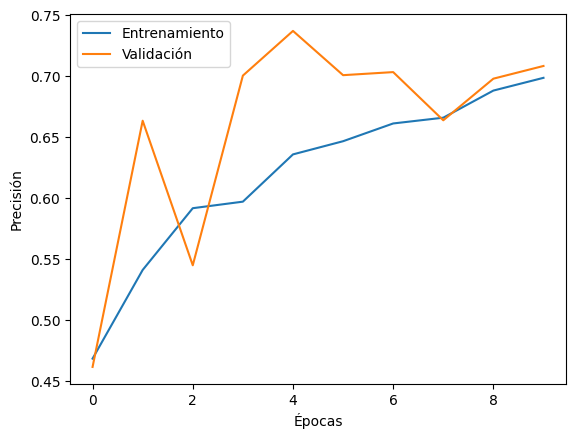

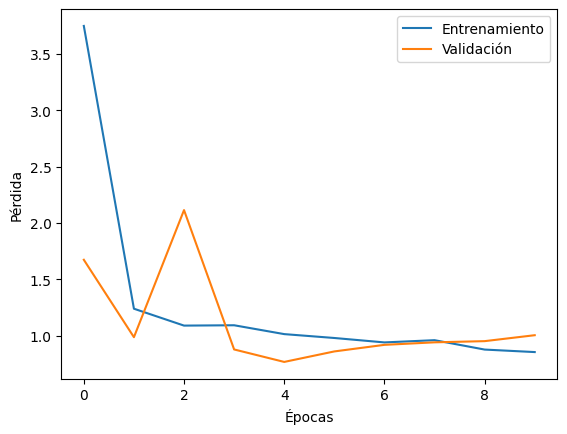

In [12]:
# Graficamos precisión CNN
plot_history_result(history_CNN)

#### Observaciones:
* Progreso del Entrenamiento: A lo largo de las 10 épocas, el modelo muestra una tendencia de mejora en la precisión del entrenamiento, incrementando de 46.8% en la primera época a 69.8% en la última. Esto indica que el modelo fue capaz de aprender patrones en los datos, mejorando su precisión en el conjunto de entrenamiento.

* Precisión y Pérdida en el Conjunto de Validación: La precisión de validación alcanzó su punto más alto en la época 10 con un 70.8%, aunque esta métrica fluctuó durante el entrenamiento. Al mismo tiempo, la pérdida de validación no sigue una tendencia clara de descenso; incluso en las últimas épocas, muestra valores más altos en comparación con el entrenamiento (por ejemplo, la pérdida de validación sube a 1.0029 en la última época). Esto sugiere que el modelo podría estar experimentando sobreajuste.

* Posible Sobreajuste: La diferencia entre la pérdida de entrenamiento y la pérdida de validación hacia el final del entrenamiento sugiere que el modelo podría estar ajustándose demasiado a los datos de entrenamiento y no generalizando bien en los datos de validación. Esto podría estar afectando el rendimiento y puede ser un área de mejora.

# MLP (Multi-Layer Perceptron)

In [13]:
modelMLP = Sequential([
    Input(input_shape),
    Flatten(),
    Dense(500, activation='relu'),
    Dropout(0.25),
    Dense(len(categories), activation='softmax'),
])

modelMLP.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history_MLP = modelMLP.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)

Epoch 1/10
351/351 [==============================] - 66s 188ms/step - loss: 5.3305 - accuracy: 0.2638 - val_loss: 1.6217 - val_accuracy: 0.3356
Epoch 2/10
351/351 [==============================] - 66s 187ms/step - loss: 1.6280 - accuracy: 0.3124 - val_loss: 1.6322 - val_accuracy: 0.3156
Epoch 3/10
351/351 [==============================] - 68s 192ms/step - loss: 1.6041 - accuracy: 0.3084 - val_loss: 1.4966 - val_accuracy: 0.3909
Epoch 4/10
351/351 [==============================] - 68s 194ms/step - loss: 1.5868 - accuracy: 0.3192 - val_loss: 1.5057 - val_accuracy: 0.3984
Epoch 5/10
351/351 [==============================] - 69s 195ms/step - loss: 1.5812 - accuracy: 0.3288 - val_loss: 1.4905 - val_accuracy: 0.3677
Epoch 6/10
351/351 [==============================] - 68s 193ms/step - loss: 1.5644 - accuracy: 0.3621 - val_loss: 1.4721 - val_accuracy: 0.4083
Epoch 7/10
351/351 [==============================] - 66s 188ms/step - loss: 1.5778 - accuracy: 0.3422 - val_loss: 1.4240 - val_ac

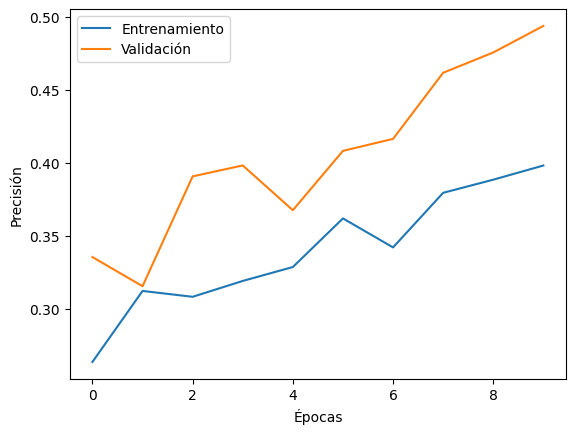

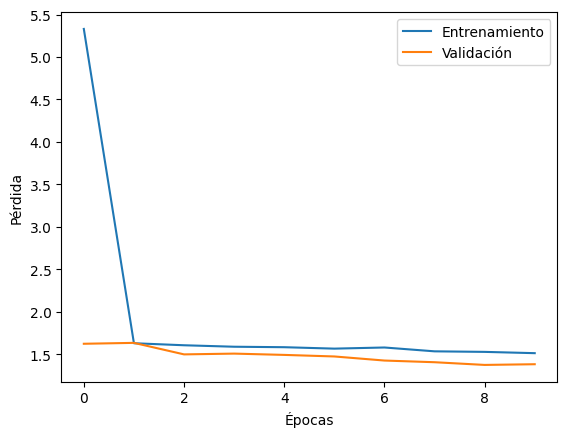

In [15]:
# Graficamos la precisión de MLP
plot_history_result(history_MLP)

#### Observaciones:
* Desempeño en el Conjunto de Entrenamiento: A lo largo de las 10 épocas, la precisión de entrenamiento del modelo MLP mostró un progreso gradual, comenzando en un 26.4% y alcanzando el 39.8%. Sin embargo, el incremento es relativamente lento, indicando que el modelo enfrenta dificultades para aprender patrones complejos en los datos.

* Precisión y Pérdida en el Conjunto de Validación: En cuanto a la validación, la precisión inicial fue de 33.5%, llegando a 49.4% en la última época. La pérdida de validación muestra una tendencia a disminuir, lo cual sugiere que el modelo va mejorando ligeramente en su capacidad de generalización.

* Capacidad Limitada del MLP: La arquitectura del MLP es mucho más simple que la de la CNN y no aprovecha la estructura espacial de las imágenes, lo cual podría explicar su rendimiento inferior. A diferencia de la CNN, que capta características espaciales a través de convoluciones, el MLP tiende a tener dificultades para captar relaciones espaciales en imágenes.

* Posible Subajuste: Los valores bajos y las lentas mejoras en precisión y pérdida tanto en el conjunto de entrenamiento como en el de validación sugieren que el modelo MLP está subajustando, es decir, no logra captar suficiente información de los datos. Esto podría deberse a la falta de capacidad del modelo para este tipo de tarea.

# ResNet-101

In [20]:
model_ResNet = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
model_ResNet.trainable = False

x = Flatten()(model_ResNet.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(len(categories), activation='softmax')(x)

model_ResNet101 = Model(inputs=model_ResNet.input, outputs=output)
model_ResNet101.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

history_ResNet101 = model_ResNet101.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10
)

Epoch 1/10
350/350 [==============================] - 440s 1s/step - loss: 1.5727 - accuracy: 0.3301 - val_loss: 1.2849 - val_accuracy: 0.4795
Epoch 2/10
350/350 [==============================] - 434s 1s/step - loss: 1.3604 - accuracy: 0.4004 - val_loss: 1.2216 - val_accuracy: 0.4677
Epoch 3/10
350/350 [==============================] - 453s 1s/step - loss: 1.3202 - accuracy: 0.4273 - val_loss: 1.1690 - val_accuracy: 0.5065
Epoch 4/10
350/350 [==============================] - 441s 1s/step - loss: 1.3072 - accuracy: 0.4275 - val_loss: 1.1337 - val_accuracy: 0.5251
Epoch 5/10
350/350 [==============================] - 441s 1s/step - loss: 1.2939 - accuracy: 0.4389 - val_loss: 1.1282 - val_accuracy: 0.5345
Epoch 6/10
350/350 [==============================] - 441s 1s/step - loss: 1.2943 - accuracy: 0.4336 - val_loss: 1.0953 - val_accuracy: 0.5639
Epoch 7/10
350/350 [==============================] - 441s 1s/step - loss: 1.2687 - accuracy: 0.4519 - val_loss: 1.1143 - val_accuracy: 0.5514

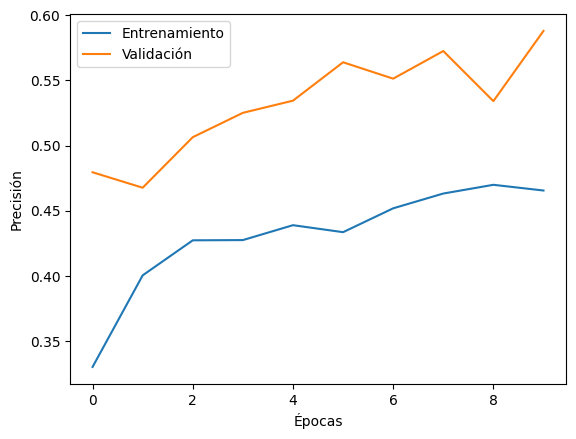

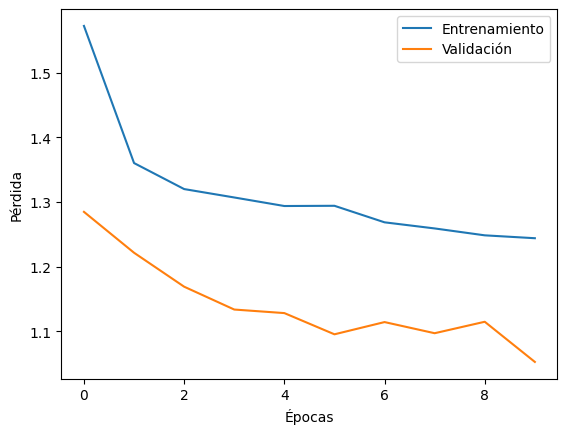

In [22]:
# Graficamos la precisión de ResNet101
plot_history_result(history_ResNet101)

#### Observaciones
Este modelo de ResNet101 muestra un rendimiento moderado en comparación con el modelo de InceptionV3 anterior, y aquí están algunos puntos clave sobre los resultados:

* Precisión y Pérdida: la precisión de entrenamiento finaliza en 46.55% y la precisión de validación en 58.80%, con una pérdida de validación de 1.0526 en la última época.
Aunque hay una mejora gradual en precisión a lo largo de las épocas, los resultados son significativamente más bajos que los obtenidos con InceptionV3, lo que sugiere que ResNet101 puede no estar capturando características específicas del dataset con esta configuración.

* Tiempos de Entrenamiento: cada época toma alrededor de 7 minutos (440 segundos), lo cual es considerablemente más lento que InceptionV3. Este tiempo elevado es común en modelos más profundos como ResNet101 y es un factor a considerar si buscas optimizar el tiempo de entrenamiento.

* Capas Densas: la arquitectura tiene una sola capa densa de 256 unidades. Puede que esta configuración sea insuficiente para capturar la variedad de patrones en tus imágenes, especialmente cuando el modelo base (ResNet101) está congelado.

# VGG19
#### Dense: 128, Dropout: 0.25

In [19]:
model_VGG19 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
model_VGG19.trainable = False

x = Flatten()(model_VGG19.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(len(categories), activation='softmax')(x)

model_VGG19_025dropout = Model(inputs=model_VGG19.input, outputs=output)
model_VGG19_025dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

history_VGG19 = model_VGG19_025dropout.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=15
)

Epoch 1/30
351/351 [==============================] - 610s 2s/step - loss: 0.7345 - accuracy: 0.7191 - val_loss: 0.4293 - val_accuracy: 0.8470
Epoch 2/30
351/351 [==============================] - 617s 2s/step - loss: 0.5826 - accuracy: 0.7831 - val_loss: 0.4204 - val_accuracy: 0.8356
Epoch 3/30
351/351 [==============================] - 488s 1s/step - loss: 0.5488 - accuracy: 0.7935 - val_loss: 0.4037 - val_accuracy: 0.8491
Epoch 4/30
351/351 [==============================] - 474s 1s/step - loss: 0.5202 - accuracy: 0.8101 - val_loss: 0.4068 - val_accuracy: 0.8509
Epoch 5/30
351/351 [==============================] - 475s 1s/step - loss: 0.5069 - accuracy: 0.8120 - val_loss: 0.4070 - val_accuracy: 0.8427
Epoch 6/30
351/351 [==============================] - 472s 1s/step - loss: 0.4926 - accuracy: 0.8175 - val_loss: 0.3882 - val_accuracy: 0.8602
Epoch 7/30
351/351 [==============================] - 471s 1s/step - loss: 0.4794 - accuracy: 0.8198 - val_loss: 0.3919 - val_accuracy: 0.8456

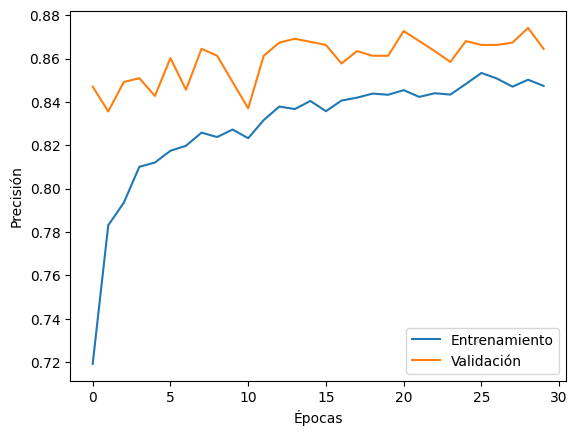

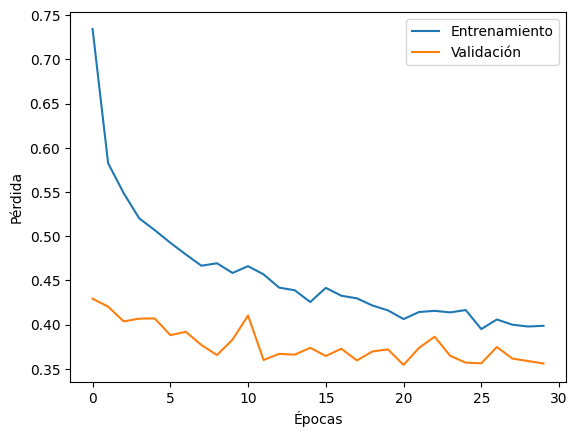

In [21]:
# Graficamos la precisión de VGG19
plot_history_result(history_VGG19)

#### Observaciones:
* Desempeño Inicial y Final: El modelo VGG19 preentrenado alcanzó una precisión de entrenamiento del 71.9% en la primera época, mejorando gradualmente hasta el 84.7% al final. En el conjunto de validación, la precisión inicial fue del 84.7%, y se mantuvo relativamente estable, alcanzando un máximo de 87.4% en la última época.

* Capacidad de Generalización: La precisión de validación se mantiene alta y estable, con una pérdida baja y en disminución, lo que indica que el modelo generaliza bien a los datos de prueba. El uso de VGG19 como extractor de características permitió al modelo aprovechar patrones complejos en las imágenes, contribuyendo al buen desempeño en validación.

* Eficiencia del Aprendizaje Transferido: Congelar las capas de VGG19 y agregar capas densas finas demostró ser eficaz, ya que el modelo evitó problemas de sobreajuste comunes cuando se entrena desde cero en conjuntos de datos más pequeños. Esto sugiere que las características aprendidas por VGG19 son relevantes para esta tarea de clasificación de imágenes.

* Estabilidad en las Últimas Épocas: Aunque el modelo sigue mejorando en entrenamiento, las métricas en validación presentan fluctuaciones menores en las últimas épocas, lo cual sugiere que el modelo está alcanzando su límite de aprendizaje bajo el esquema actual.

# VGG19
#### Dense: 256, Dropout: 0.15

In [ ]:
VGG19_dense256_dropout015 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
VGG19_dense256_dropout015.trainable = False

x = Flatten()(VGG19_dense256_dropout015.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.15)(x)
output = Dense(len(categories), activation='softmax')(x)

model_VGG19_025dropout = Model(inputs=VGG19_dense256_dropout015.input, outputs=output)
model_VGG19_025dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

history_VGG19_dense256_dropout015 = model_VGG19_025dropout.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=10
)

In [ ]:
# Graficamos la precisión de VGG19_dense256_dropout015
plot_history_result(history_VGG19_dense256_dropout015)

# InceptionV3
#### Dense: 256, Dropout: 0.25

In [10]:
model_InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
model_InceptionV3.trainable = True
for layer in model_InceptionV3.layers[:-20]:  # Desbloquear solo las últimas 20 capas
    layer.trainable = False

x = Flatten()(model_InceptionV3.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(len(categories), activation='softmax')(x)

optimizer_fine = Adam(learning_rate=0.00001)
model_InceptionV3 = Model(inputs=model_InceptionV3.input, outputs=output)
model_InceptionV3.compile(optimizer=optimizer_fine, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

history_model_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=15
)

c:\users\ulises\appdata\local\programs\python\python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.6372 - loss: 0.9869

c:\users\ulises\appdata\local\programs\python\python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


350/350 ━━━━━━━━━━━━━━━━━━━━ 237s 655ms/step - accuracy: 0.6376 - loss: 0.9861 - val_accuracy: 0.8578 - val_loss: 0.4148
Epoch 2/15
  1/350 ━━━━━━━━━━━━━━━━━━━━ 2:53 497ms/step - accuracy: 0.7500 - loss: 0.8531

c:\users\ulises\appdata\local\programs\python\python39\lib\contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)


350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7500 - loss: 0.8531 - val_accuracy: 0.7500 - val_loss: 0.5828
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 229s 653ms/step - accuracy: 0.8249 - loss: 0.4902 - val_accuracy: 0.8779 - val_loss: 0.3559
Epoch 4/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step - accuracy: 0.9375 - loss: 0.1685 - val_accuracy: 0.9000 - val_loss: 0.5352
Epoch 5/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 227s 648ms/step - accuracy: 0.8384 - loss: 0.4265 - val_accuracy: 0.8890 - val_loss: 0.3366
Epoch 6/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - accuracy: 0.8438 - loss: 0.8567 - val_accuracy: 0.8500 - val_loss: 0.2627
Epoch 7/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 228s 651ms/step - accuracy: 0.8499 - loss: 0.4018 - val_accuracy: 0.8930 - val_loss: 0.3122
Epoch 8/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7812 - loss: 0.4422 - val_accuracy: 0.9000 - val_loss: 0.6059
Epoch 9/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 228s 650ms/step - accuracy: 0.8654 - loss: 0.3847 - val_acc

In [ ]:
# Graficamos la precisión de InceptionV3_dense256_dropout025
plot_history_result(history_model_InceptionV3)

#### Observaciones:
Este modelo con InceptionV3 mostró una mejora en comparación con el de VGG19, especialmente en términos de la precisión en el conjunto de validación. 
* Precisión: en el conjunto de validación con InceptionV3 se estabiliza alrededor del 89% después de unas pocas épocas y alcanza hasta el 89.7% en algunos puntos, lo que es una mejora respecto a la precisión obtenida con VGG19, que rondaba el 87-88%.
La precisión final de entrenamiento también es superior, alcanzando el 86.99%.

* Pérdida: en el conjunto de validación con InceptionV3 ha sido generalmente más baja que con VGG19, con valores consistentemente en el rango de 0.3. Esto indica que el modelo ha aprendido características que generalizan mejor al conjunto de validación.
A diferencia de VGG19, InceptionV3 logra una disminución más estable en la pérdida, lo que puede significar que su arquitectura es mejor para captar patrones de características de tu dataset.

* Tiempo de entrenamiento: el modelo es considerablemente más rápido que el de VGG19, con un tiempo promedio de 115 segundos por época, frente a los más de 450 segundos de VGG19. Esto indica que InceptionV3 puede ser más adecuado para realizar pruebas adicionales y ajustar el modelo, ya que permite experimentar en menos tiempo.

In [17]:
get_csv(img_folder_test, model_InceptionV3, 'model_InceptionV3_dense256_dropout025')

94/94 [==============================] - 22s 230ms/step
Predicciones guardadas en 'model_InceptionV3_dense256_dropout025.csv'


# InceptionV3
#### Dense: 512, Dropout: 0.25, Dense: 256, Dense: 128

In [14]:
from tensorflow.keras.regularizers import l2
model_InceptionV3_3layers = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
model_InceptionV3_3layers.trainable = True
for layer in model_InceptionV3_3layers.layers[:-20]:  # Desbloquear solo las últimas 20 capas
    layer.trainable = False

x = Flatten()(model_InceptionV3_3layers.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  # Regularización L2
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

output = Dense(len(categories), activation='softmax')(x)
optimizer_fine = Adam(learning_rate=0.00001)
model_InceptionV3_3layers = Model(inputs=model_InceptionV3_3layers.input, outputs=output)
model_InceptionV3_3layers.compile(optimizer=optimizer_fine, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

history_model_InceptionV3_3layers = model_InceptionV3_3layers.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=30
)

Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 245s 676ms/step - accuracy: 0.6318 - loss: 2.0862 - val_accuracy: 0.8591 - val_loss: 1.4255
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 236s 672ms/step - accuracy: 0.8092 - loss: 1.5652 - val_accuracy: 0.8670 - val_loss: 1.4036
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 235s 670ms/step - accuracy: 0.8310 - loss: 1.4780 - val_accuracy: 0.8748 - val_loss: 1.3758
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 235s 670ms/step - accuracy: 0.8351 - loss: 1.4468 - val_accuracy: 0.8798 - val_loss: 1.3523
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 235s 670ms/step - accuracy: 0.8446 - loss: 1.418

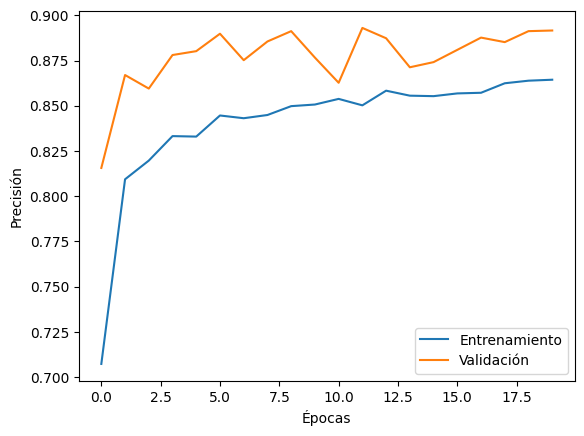

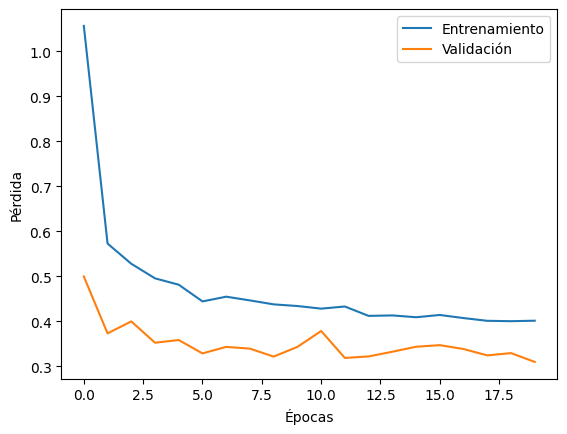

In [19]:
# Graficamos la precisión de InceptionV3_3layers
plot_history_result(history_model_InceptionV3_3layers)

#### Observaciones
Este modelo de InceptionV3 con tres capas densas adicionales muestra un rendimiento notable, y algunos aspectos clave de los resultados son los siguientes:

* Precisión y Pérdida: la precisión final en el conjunto de validación alcanza hasta un 89.16% y la pérdida se reduce a 0.3099 en la última época. Esto sugiere que añadir capas densas adicionales ha permitido al modelo captar mejor las características de tu dataset, en especial comparado con el modelo anterior.
En general, este modelo parece tener un rendimiento de validación estable y con un buen equilibrio entre la precisión y la pérdida, manteniéndose por encima del 87% de precisión en la mayoría de las épocas.

* Mejoras en la Arquitectura: las capas adicionales de 512, 256 y 128 unidades, junto con Dropout (0.25), han ayudado a crear una arquitectura más robusta y capaz de captar patrones complejos. Esto también le da al modelo una mayor capacidad de representación sin aumentar mucho el sobreajuste.

* Tiempo de entrenamiento: a pesar de agregar capas adicionales, el tiempo por época sigue siendo similar al modelo InceptionV3 anterior, alrededor de 120 segundos, lo cual es manejable y te permite experimentar con más configuraciones si lo deseas.

* Curva de entrenamiento: aunque la precisión de validación es alta, en algunas épocas la pérdida tiende a oscilar. Esto podría deberse a que el modelo aún encuentra difícil generalizar completamente en todas las muestras de validación, lo que se podría afinar con un ajuste más detallado.

# Conclusiones:
